# <p style="text-align:center">Lecture 3. E-Cell4の構造</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

In [1]:
!pip install ecell4

In [0]:
%matplotlib inline
from ecell4 import *
from ecell4_base.core import *
from ecell4_base import *

In [0]:
import seaborn
seaborn.set(font_scale=1.5)

In [0]:
import matplotlib as mpl
# mpl.rc("figure", figsize=(8.0, 5.5))
mpl.rc("figure", figsize=(6, 4))

## E-Cell4の基本要素

E-Cell4を使う上で理解しなければならない3つの要素として`Model`、`World`、`Simulator`があり、計算における異なる概念をあらわしている。

- `Model`: いわゆるモデル。分子の特徴量（拡散定数、大きさなど）や反応を記述したもの。具体的には`NetworkModel`を使う。

- `World`: ある時刻における状態をあらわすもの。分子の数や位置、空間の表現法など。使う`World`はアルゴリズムによって異なる. 例えば、`ode.World`みたいな感じ。

- Simulator: 時間発展に関する計算手法をまとめたもの。ソルバーとも言う。例えば、`ode.Simulator`みたいな感じ。

## E-Cell4におけるModelの基本

Modelは扱う問題を記述したもので、大きく2つの要素によって構成されている。

- `Species`: すなわち分子種。モデルに登場する実体をあらわす。
- `ReactionRule`: すなわち反応則。分子種（`Species`）間の相互作用をあらわす。

E-Cell4では主に化学反応を扱うので、それを例に言えば

- `Species`: 基質や酵素などどんな種類の分子が存在し、それらがどのような性質 (分子の大きさなど)を持つかをあらわす。
- `ReactionRule`: 結合やかい離などそれら分子間にどのような反応があるかをあらわす。

## 分子種 `Species`

E-Cell4を使って`Species`を作るには

In [0]:
A = Species('A')
B = Species('B')

とすれば良い。

それぞれ、AとBという名前の分子種をあらわす。1個の特定の分子ではなく、そういう種類の分子があることを意味している。

`Species`には任意の属性を持たせることで、どのような性質を持つのかを指定できる。

In [0]:
A = Species("A")
A.set_attribute("radius", 0.005)
A.set_attribute("D", 1)
A.set_attribute("location", "cytoplasm")

1つ目に与える引数が属性名で、2つ目がその値で、属性名は文字列で値は文字列か数値、真偽値でなければならない。

属性のうち特に分子径、拡散係数、属する場所は頻繁に用いられるので簡単に

In [0]:
A = Species("A", 0.005, 1, "cytoplasm")  # XXX: serial, radius, D, location

でまとめて与えることができる。

与えたSpeciesの属性を知りたいときは

In [8]:
print(A.serial())
print(A.get_attribute("radius").magnitude)
print(A.get_attribute("D").magnitude)
print(A.get_attribute("location"))

A
0.005
1.0
cytoplasm


とすれば良い。数値属性は単位を伴った`Quantity`として返されるので`magnitude`によって値だけ取り出せる。

In [0]:
del A, B

## 反応則 `ReactionRule`

`Species`ができたところで今度は反応を作ってみる。

反応はおおざっぱに言って、何かの分子種が何かの分子種になること。

前者をReactants、後者をProductsと呼ぶ。あとはその反応の速さ（速度定数）を数値で与えれば良い。

In [0]:
rr = ReactionRule()
rr.add_reactant(Species("A"))
rr.add_product(Species("B"))
rr.set_k(1.0)

これで分子種`A`が分子種`B`に変る反応を作れた。ここでは反応を定義しているので、`Species`に属性値はなくても良い。

確認してみる。与えられた`ReactionRule`がどのようなものかを簡単に知りたい場合は`as_string`関数で見られる。

In [11]:
print(rr.as_string())

A>B|1


結合もこれと同じに記述できる。`A`と`B`の結合によって`C`ができる。

In [12]:
rr = ReactionRule()
rr.add_reactant(Species("A"))
rr.add_reactant(Species("B"))
rr.add_product(Species("C"))
rr.set_k(1.0)

print(rr.as_string())

A+B>C|1


より読み手に伝わりやすい書き方として以下の便利関数も用意されている。

In [0]:
rr1 = create_unimolecular_reaction_rule(
    Species("A"), Species("B"), 1.0)
rr2 = create_binding_reaction_rule(
    Species("A"), Species("B"), Species("C"), 1.0)
rr3 = create_unbinding_reaction_rule(
    Species("C"), Species("A"), Species("B"), 1.0)

## ネットワークモデル `NetworkModel`

以上で`Model`に含まれる要素を作れるようになった。

In [0]:
sp1 = Species("A", 0.005, 1.0)
sp2 = Species("B", 0.005, 1.0)
sp3 = Species("C", 0.010, 0.5)
rr1 = create_binding_reaction_rule(
    Species("A"), Species("B"), Species("C"), 0.01)
rr2 = create_unbinding_reaction_rule(
    Species("C"), Species("A"), Species("B"), 0.3)

あとはこれらを`Model`に追加していく。

`Species`の追加は`add_species_attribute`で、`ReactionRule`の追加は`add_reaction_rule`で行う。

In [0]:
m = NetworkModel()
m.add_species_attribute(sp1)
m.add_species_attribute(sp2)
m.add_species_attribute(sp3)
m.add_reaction_rule(rr1)
m.add_reaction_rule(rr2)

これで簡単な結合とかい離のモデルを作ることができた。

モデルの中身を取り出すときには`species_attributes`と`reaction_rules`を使う。`list_species`はまた別物なので注意！

In [16]:
print(m.species_attributes())
print(m.reaction_rules())

[<ecell4_base.core.Species object at 0x7f14918c5bd0>, <ecell4_base.core.Species object at 0x7f14918c5be8>, <ecell4_base.core.Species object at 0x7f14918c5c00>]
[<ecell4_base.core.ReactionRule object at 0x7f14918c5bd0>, <ecell4_base.core.ReactionRule object at 0x7f14918c5be8>]


ちなみに、特に`Species`の属性を必要としない計算(常微分方程式やGillespie法)では`add_species_attribute`は省略しても良い。

## E-Cell4を使ってModelを簡単に計算してみる

`World`と`Simulator`の説明がまだだが、早くシミュレーションを走らせたい人のためにここで一度計算を行なってみる。

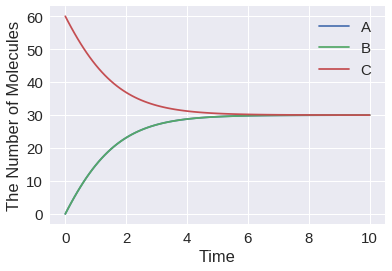

In [17]:
# XXX: 'm' is a NetworkModel, which is described in the section above.
run_simulation(10, {'C': 60}, volume=1.0, model=m)

`run_simulation`は分子数を記録して時系列をプロットしてくれる。

- 1つ目の引数は計算時間で、今回は10秒間（0.1秒刻み）。
- 2つ目の引数は初期値で、分子種`C`を60分子とした。
- `volume`は計算する空間の容積。
- `model`はモデル。先程の`NetworkModel`を与えた。

この味気ないプロットに満足できない人のためには確率論的計算手法というものがある。

- Gillespie D.T., "Exact stochastic simulation of coupled chemical reactions", J. Phys. Chem., 81(25), 2340–2361 (1977)

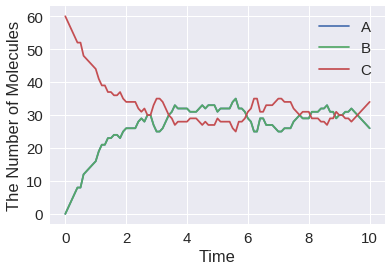

In [18]:
run_simulation(10, {'C': 60}, volume=1.0, model=m, solver='gillespie')

全く同じモデルを異る手法で計算することができた。これは問題と計算手法が分離されているからこそなせる技である。

## モデルを記述するE-Cell4の特殊記法

E-Cell4を使って`Species`と`ReactionRule`を作り、`NetworkModel`に登録して簡単に計算することができるようになった。

しかし、モデルの記述はこのように簡単な結合とかい離だけであっても煩雑でモデルの読み手に伝わりづらい。

そこで、E-Cell4ではこのモデルを記述するための独自の構文をいくつか勝手に用意している。

まずは`ReactionRule`について見てみると、

In [0]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m = get_model()

- 特殊記法を使う時には`with`ステートメントを利用する。この下でインデントを続けている限りは特殊構文が利用できる。
- `reaction_rules`のあとに`()`を忘れずに。
- 構文については見ての通りで、セパレータ`|`の後に反応速度定数として数値を1つだけ与える。
- 構文自体はあくまでもPythonであるため、不要な改行は許されない。

また、可逆反応については特別な記法があり、それを使えばより簡単になる。

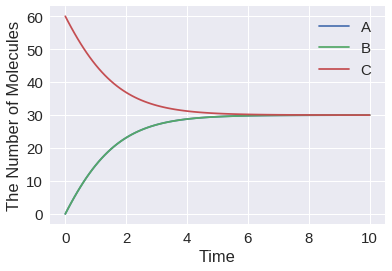

In [20]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

run_simulation(10, {'C': 60})

可逆反応の記号は`==`で、セパレータの後には`tuple`を用いて2つの速度定数を与える。

`run_simulation`関数は引数`model`を指定しない場合は自分で`get_model()`を呼んでモデルとするので、このように省略可能な場合がある。

$${\frac{\mathrm{d[A]}}{\mathrm{d}t}=\frac{\mathrm{d[B]}}{\mathrm{d}t}=-0.01\mathrm{[A][B]}+0.3\mathrm{[C]}\\
\frac{\mathrm{d[C]}}{\mathrm{d}t}=+0.01\mathrm{[A][B]}-0.3\mathrm{[C]}
}$$

### 発現や分解の記述

発現や分解の反応では、反応の左辺か右辺がなにもないことになるが、E-Cell4の特殊記法では残念ながらこれらをそのまま書くことはできない。

例えば、

In [21]:
with reaction_rules():
    A > | 1.0  # XXX: will throw SyntaxError
    > A | 1.0  # XXX: will throw SyntaxError

SyntaxError: ignored

これらを表現するために特殊記号`~`を用いる。

`ReactionRule`を記述する際に`Species`の前に`~`記号を置くと反応上のその分子種の量論係数が0になる。簡単に言えば、単に無いものとみなされる。

In [0]:
with reaction_rules():
    A > ~A | 1.0  # XXX: create_degradation_reaction_rule
    ~A > A | 1.0  # XXX: create_synthesis_reaction_rule

$${\frac{\mathrm{d[A]}}{\mathrm{d}t}=1.0-1.0\mathrm{[A]}}$$

In [0]:
m = get_model()

## 常微分方程式ソルバで`World`と`Simulator`

`Model`が理解できれば`World`と`Simulator`はさほど難しくはない。

さきほどの`run_simulation`関数で与えた`volume`と`{'C': 60}`などが`World`で、`solver`が`Simulator`に相当する。

実際に`run_simulation`がしている作業を自分で書けるようにする。

`run_simulation`は標準で常微分方程式ソルバ`ode`を使う。

### `ode.World`の準備

まずは`World`を作る。

In [0]:
w = ode.World(Real3(1, 1, 1))

- `Real3`は3つの実数値をまとめた3次元ベクトル。`ones()`としても`Real3(1, 1, 1)`が得られる。
- `World`は1つ目の引数として直方体の三辺の長さを受け取る。この例では一辺が1の立方体とした。

In [25]:
print(w.t())
print(w.edge_lengths())
print(w.volume())

0.0
1.0


- 時刻は`t`関数で得られる。
- 引数に与えた直方体の三辺は`edge_lengths`関数。
- 直方体の体積だけ知りたければ`volume`関数。

箱ができたので次は実際に分子を加えてみる.

In [26]:
w.add_molecules(Species('C'), 60)
print(w.num_molecules(Species('C')))

60


- 分子を加えるときは`add_molecules`。
- 減らすときはl`remove_molecules`。
- その数を知りたければ`num_molecules`。

どれも1つ目の引数は問題とする分子種`Species`。

ただし、`ode`ソルバでは分子数は実数値として扱われるが、これらの関数では整数値しか扱うことができない。

実数を扱いたい場合は`set_value`と`get_value`を使う。

### ODESimulatorの作成と実行

`Simulator`は`Model`と`World`を与えることで作れる。

In [0]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

In [0]:
sim = ode.Simulator(w, m)

あとは`run`関数を呼べば計算が行われる。

In [0]:
sim.run(10)

`World`の状態がどう変わったかをみてみよう。計算が進み、`C`の数が減っている。

In [30]:
print(w.t(), w.num_molecules(Species('C')))

10.0 30


`World`はあくまでも現在もしくはある時点での状態を表すもので、これだけでは途中の経過を追うことができない。

時系列を得るためには`Observer`を使う。

In [31]:
obs = FixedIntervalNumberObserver(1, ('A', 'B', 'C'))
sim.run(10, obs)
print(obs.data())

[[10.0, 29.99444517371379, 29.994445173713803, 30.005554826286183], [11.0, 29.99774041252827, 29.997740412528284, 30.002259587471702], [12.0, 29.99908086688785, 29.999080866887866, 30.00091913311212], [13.0, 29.99962612723216, 29.999626127232172, 30.000373872767813], [14.0, 29.999847921543797, 29.99984792154381, 30.000152078456175], [15.0, 29.999938139856496, 29.99993813985651, 30.000061860143475], [16.0, 29.999974837493898, 29.999974837493912, 30.000025162506073], [17.0, 29.999989764789976, 29.99998976478999, 30.000010235209995], [18.0, 29.99999583668202, 29.999995836682036, 30.00000416331795], [19.0, 29.999998306510967, 29.99999830651098, 30.000001693489004], [20.0, 29.99999931114916, 29.999999311149175, 30.00000068885081]]


`Observer`には様々な種類があるが、時系列を得るには`FixedIntervalNumberObserver`を使う。

決まった時間幅で分子数を記録する。1つ目の引数が時間幅で、2つ目の引数が分子種。その結果は`data`関数で引き出せる。

`viz.plot_number_observer`関数で簡単に時系列をプロットすることもできる（単に`show`としても良い）。

### まとめ

ここまでの内容をまとめて書くと、

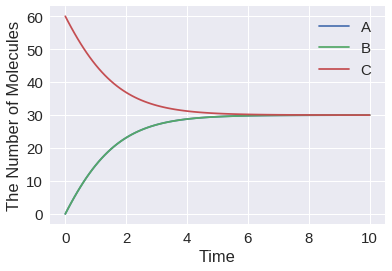

In [32]:
w = ode.World(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)

sim = ode.Simulator(w, m)
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

viz.plot_number_observer(obs)

### ソルバを切り替える

`run_simulation`で試した通り、確率論的手法に切り替えることはさほど難しくない。

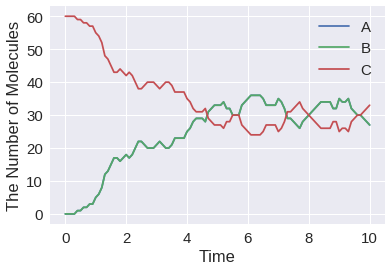

In [33]:
# ode.World -> gillespie.World
w = gillespie.World(ones())
w.add_molecules(Species('C'), 60)

# ode.Simulator -> gillespie.Simulator
sim = gillespie.Simulator(w, m)
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

show(obs)

## 練習問題

- **`Model`に関する練習**： モデルといえば振動モデルが華だが、今回は質量作用則以外の反応式は使えない。質量作用則だけを用いて振動モデルを作るためにはいくつの反応が必要だろうか？できるだけ少ない反応数で作る方法はないか？

- **`run_simulation`に関する練習**: `gillespie`ソルバは確率論的手法と呼ばれているが、分子の数が多くなれば、決定論的な結果に近づくと考えられる。実際に容積や分子数を増やしてみて、その結果がどうなるか確認する。

- **`World`と`Simulator`に関する練習**: `run_simulation`関数では連続した計算しかできない。`World`と`Simulator`を使って、計算を5秒間行った後、分子の数を変えて再び5秒の計算を行ってみる。また、その結果を`Observer`を用いてプロットしてみよう。ただし、`World`の状態を変えた場合は`Simulator`を`initialize()`しなければならないので注意。

- **`Observer`に関する練習**: `viz.plot_number_observer`関数は複数の`NumberObserver`を受け取って重ねてプロットすることができる。そこで、1つのモデルを作成し、`ode`と`gillespie`のそれぞれでシミュレーションを行い,結果を記録した2つの`Observer`を同時に表示させて比較する。